# Study of different models

Our objective is to model the data previously studied in *00_EDA.ipynb*. We are going to train differents Machine Learning Models and select the best one.

- First we will make a base model, (imputing to all the majority class, i.e., assuming for all cases that there is no fraud).

- After having this base model, we will run a series of models and see what results are obtained.

- We will print all the metrics and below we will comment on the conclusions obtained.

- We are going to focus on the f2-score metric, due to false negatives are more costly, understanding that there is one class more important than another, in this case undetected frauds are more costly than detecting a non-fraudulent transaction as fraudulent, since false negatives are more costly. 

We have chosen the F2-score because of this image, following the processes and coming to the conclusion that the metric we are interested in is the F2-score.
<img src='../images/F2 score.png'>

### Libraries

In [1]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline 

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import r2_score, precision_recall_curve, recall_score, precision_score, auc, classification_report, fbeta_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
from aux_func import plot_metrics, plot_threshold

### Read Pre-Processed Data


In [3]:
# Archivos
path = '../data/processed/'
new_file = 'new_dataset_payments_fraud.parquet'

In [4]:
df = pd.read_parquet(path+new_file)

In [5]:
df.head()

,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,...,device_1,device_2,device_3,device_4,zone_1,zone_2,zone_3,zone_4,Transaction_type_1,Transaction_type_2
0,1,9839.64,0.140039,170136.0,85,160296.36,138,5,1,0.0,...,1,0,0,0,1,0,0,0,1,0
1,1,1864.28,0.496890,21249.0,57,19384.72,909,1,0,0.0,...,1,0,0,0,0,1,0,0,1,0
2,1,181.00,0.781150,181.0,66,0.00,2569,10,0,0.0,...,0,1,0,0,1,0,0,0,0,1
3,1,181.00,0.565068,181.0,31,0.00,1787,3,0,21182.0,...,1,0,0,0,0,1,0,0,0,1
4,1,11668.14,0.517114,41554.0,90,29885.86,3997,8,0,0.0,...,1,0,0,0,0,1,0,0,1,0


### Training and test split

As the target variable is very unbalanced, we will split between train and test with stratify. This allows us to keep the same proportion of the target variable in both parts.

In [6]:
X = df.drop('isFraud',axis = 1)  # data
Y = df.isFraud # target

In [7]:
# Parameters
seed = 1243
test_size = 0.3

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=seed, test_size= test_size )

We check that the Train and the Test have the same proportion of the target variable.

In [9]:
print(f'Train:\n - Label 1, {len(y_train[y_train==1])}\n - Label 0, {len(y_train[y_train==0])} ')
print(f'Test:\n - Label 1, {len(y_test[y_test==1])}\n - Label 0, {len(y_test[y_test==0])} ')

print(f'Rate of label 1 in Train: {len(y_train[y_train==1])/len(x_train)}')
print(f'Rate of label 1 in Test: {len(y_test[y_test==1])/len(x_test)}')

Train:
 - Label 1, 799
 - Label 0, 733203 
Test:
 - Label 1, 343
 - Label 0, 314230 
Rate of label 1 in Train: 0.0010885528922264518
Rate of label 1 in Test: 0.0010903669418545138


### Variable scaling

In some algorithms it is not necessary to scale the variables, but if it is done, nothing happens.

We scale the data with MinMaxScaler, which scales the variables between [0, 1] or between [-1, 1] if there are negative values.

In [10]:
scaler = MinMaxScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns, index=x_test.index)

###  Adding synthetic data to train

As it is very unbalanced, we add synthetic data in the Train part, so that we can have more data with the label "1" in the *isFraud* column.

We use oversampling technique, we increase the number of data with label "1".

In [11]:
# Parameters
alpha = {1: 15000}
# alpha = 35/65 # Define Ratio

In [12]:
smote_method = SMOTE(sampling_strategy=alpha, random_state=seed, )
# Apply resampling to the training data only
x_train_resampled, y_train_resampled = smote_method.fit_resample(x_train_scaled, y_train)

In [13]:
print(f'Data Set Train Original: {Counter(y_train)}')
print(f'Data Set Train Balanced: {Counter(y_train_resampled)}')

Data Set Train Original: Counter({0: 733203, 1: 799})
Data Set Train Balanced: Counter({0: 733203, 1: 15000})



#### ¡ Important !

- After several tests we have realized that the results are better without adding synthetic data. The models will be trained with *x_train_scaled*, without using *x_train_resampled* and *y_train_resampled*.
- We have decided to leave the code of how the Over Sampling would be done, in case we need it in the future.


## Base Model

We will set all the predictions as the majority class and we will mark this model as the reference model to later contrast it with the rest of the models we train.

Dummy Classifier

In [14]:
clf_dummy = DummyClassifier(strategy="most_frequent")
clf_dummy.fit(x_train_scaled, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
y_pred_dummy = clf_dummy.predict(x_test_scaled)
y_pred_dummy_prob = clf_dummy.predict_proba(x_test_scaled)

### Metrics


F2 Score: 0.4998908681107711

R2 Score: -0.0010915571396750146

Accuracy Score: 0.9989096330581455

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.00      0.00      0.00       343

    accuracy                           1.00    314573
   macro avg       0.50      0.50      0.50    314573
weighted avg       1.00      1.00      1.00    314573



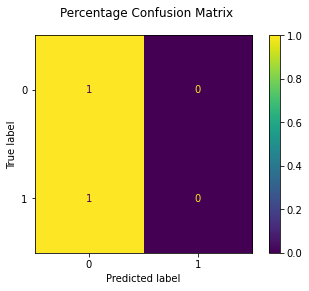

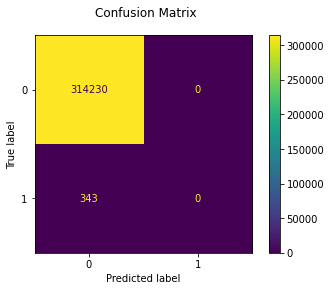

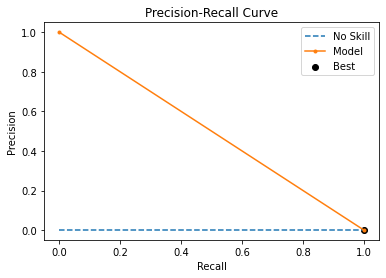

Model PR AUC: 0.5005451834709272
Best Threshold=0.000000, F-Score=0.002


In [16]:
plot_metrics(y_test, y_pred_dummy, y_pred_dummy_prob, Y)

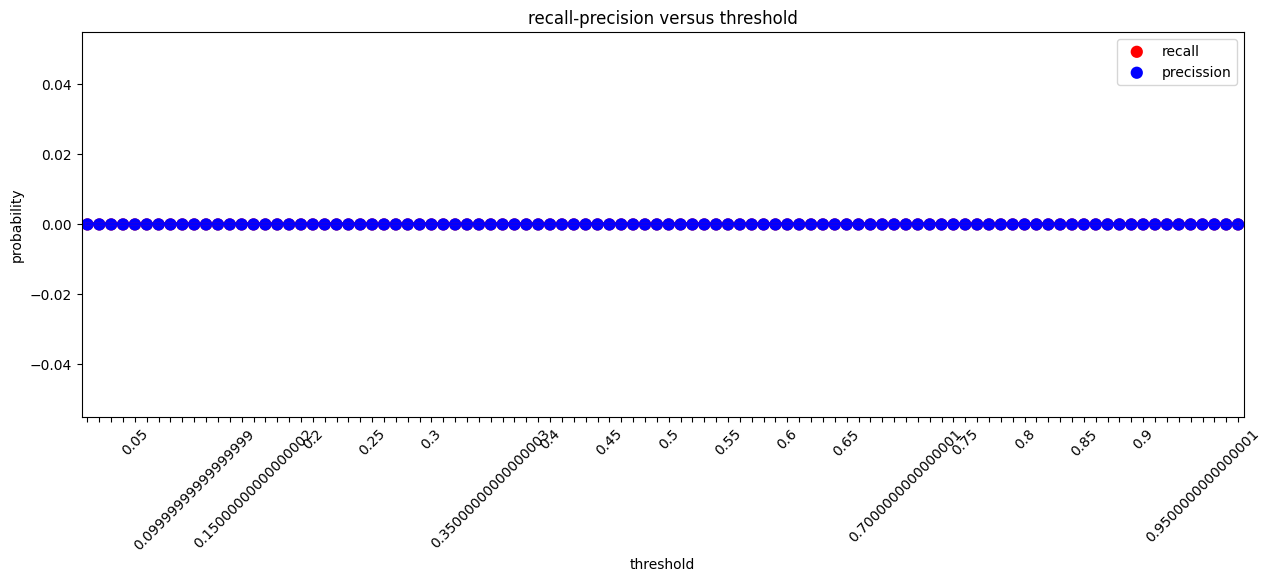

In [17]:
plot_threshold(clf_dummy, x_train_scaled, x_test_scaled, y_train, y_test)

# Models to study:
- Logistic Regression + Lasso
- Select Variables
- GLM
- SVM
- RandomForest
- XGBBoost
- LightGBM
- K-Means
- Naive Bayes

## Logistic Regression + Lasso

- First we will perform a logistic regression without Lasso.
- Finally we will perform Logistic Regression+Lasso using the function *penalty='l1'*.

### Logistic Regression

In [18]:
# clf_logistic = LogisticRegression()
# clf_logistic.fit(x_train_scaled, y_train)

In [19]:
filename = '../models/Logistic_model.sav'
# save the model to disk
# pickle.dump(clf_logistic, open(filename, 'wb'))
 
# load the model from disk
clf_logistic = pickle.load(open(filename, 'rb'))

In [20]:
y_pred_logistic = clf_logistic.predict(x_test_scaled)
y_pred_logistic_prob = clf_logistic.predict_proba(x_test_scaled)

Results obtained before the lasso:


F2 Score: 0.560356875756082

R2 Score: 0.09814200829107989

Accuracy Score: 0.9990177160786209

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       1.00      0.10      0.18       343

    accuracy                           1.00    314573
   macro avg       1.00      0.55      0.59    314573
weighted avg       1.00      1.00      1.00    314573



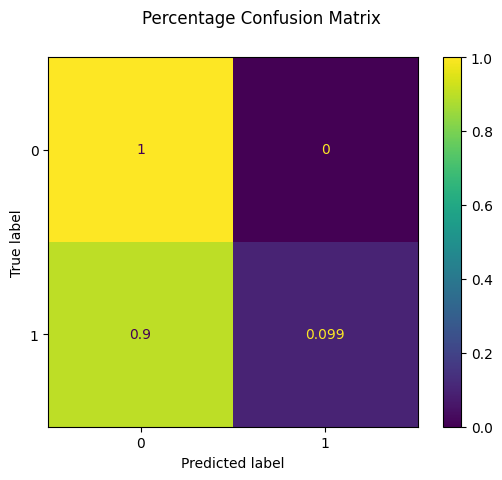

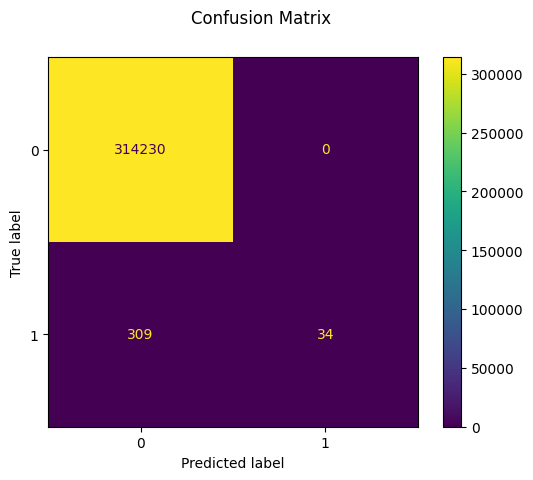

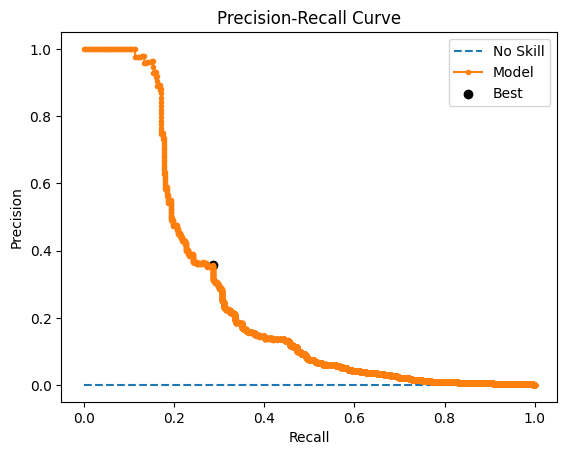

Model PR AUC: 0.26657387723661463
Best Threshold=0.087318, F-Score=0.317


In [21]:
plot_metrics(y_test, y_pred_logistic, y_pred_logistic_prob, Y)

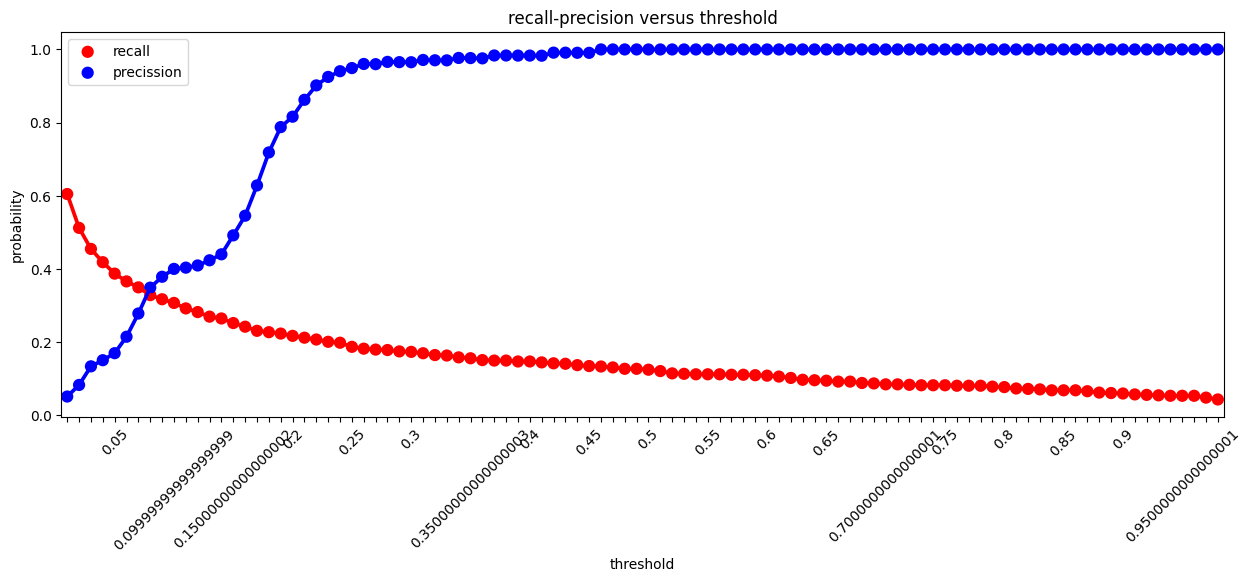

In [22]:
plot_threshold(clf_logistic, x_train_scaled, x_test_scaled, y_train, y_test)

### Logistic Regression + Lasso

We performed Lasso. This will allow us to rule out some variables.

In [23]:
# clf_LogisticLasso = LogisticRegression(penalty='l1', random_state=seed, solver='liblinear')
# clf_LogisticLasso.fit(x_train_scaled, y_train)

In [24]:
filename = '../models/LogisticLasso_model.sav'
# save the model to disk
# pickle.dump(clf_LogisticLasso, open(filename, 'wb'))
 
# load the model from disk
clf_LogisticLasso = pickle.load(open(filename, 'rb'))

#### Select Variables

We see the variables that we would select with a threshold of 0.08

In [91]:
sel_lasso = SelectFromModel(clf_LogisticLasso, threshold = 0.08)
sel_lasso.get_support()
selected_feat_lasso = x_train_scaled.columns[sel_lasso.get_support()]
print('total features: {}'.format((x_train_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))
selected_feat_lasso

total features: 28
selected features: 14


Index(['amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'newbalanceDest', 'HourOfDay', 'Day', 'type_1', 'type_2', 'type_4',
       'type_5', 'device_3', 'zone_3', 'Transaction_type_1'],
      dtype='object')

We choose with 14 variables out of the 28 total.

In [25]:
y_pred_logisticlasso = clf_LogisticLasso.predict(x_test_scaled)
y_pred_logisticlasso_prob = clf_LogisticLasso.predict_proba(x_test_scaled)


F2 Score: 0.6794411073958972

R2 Score: 0.279097333488339

Accuracy Score: 0.99921480864537

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.91      0.31      0.46       343

    accuracy                           1.00    314573
   macro avg       0.95      0.66      0.73    314573
weighted avg       1.00      1.00      1.00    314573



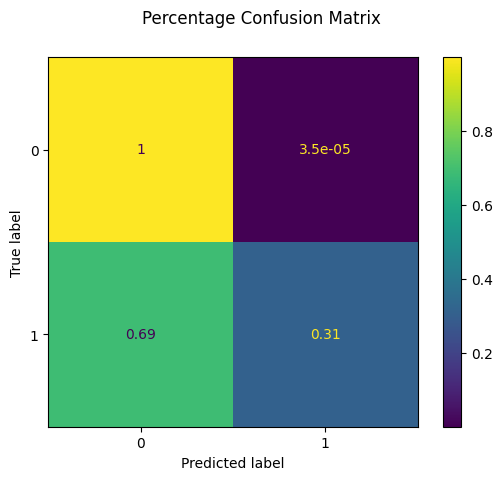

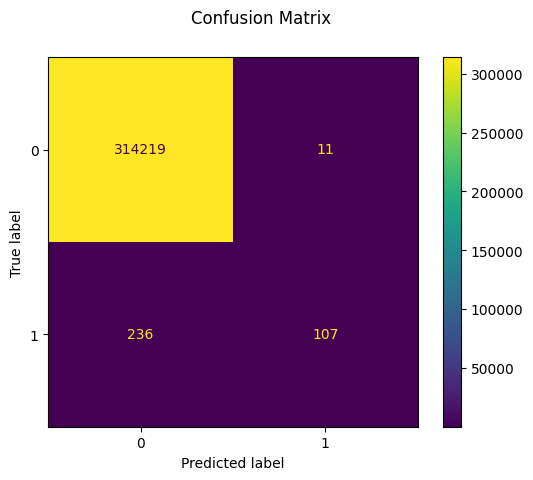

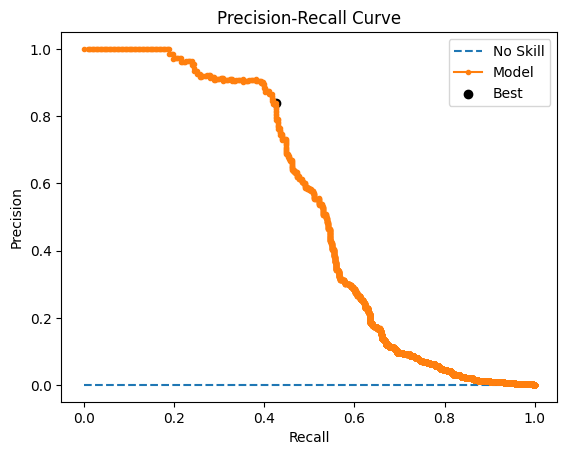

Model PR AUC: 0.5268396143917401
Best Threshold=0.216559, F-Score=0.565


In [26]:
plot_metrics(y_test, y_pred_logisticlasso, y_pred_logisticlasso_prob, Y)

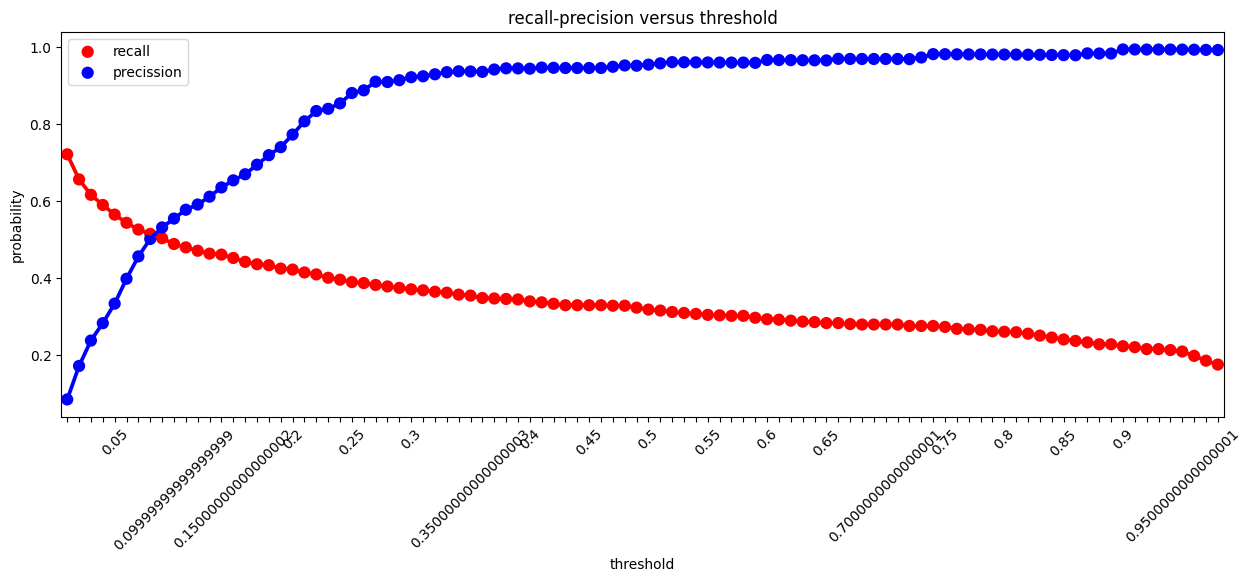

In [27]:
plot_threshold(clf_LogisticLasso, x_train_scaled, x_test_scaled, y_train, y_test)

## GLM

#### Linear Regression

In [28]:
# clf_LinearReg = LinearRegression()
# clf_LinearReg.fit(x_train_scaled, y_train)

In [29]:
filename = '../models/LinearReg_model.sav'
# save the model to disk
# pickle.dump(clf_LinearReg, open(filename, 'wb'))
 
# load the model from disk
clf_LinearReg = pickle.load(open(filename, 'rb'))

In [30]:
y_pred_LinearReg = clf_LinearReg.predict(x_test_scaled)

The linear regression algorithm does not make sense in our problem, since it is NOT a classification algorithm.
Within the linear models we find the RidgeClassifier Model, which is useful for classification problems.

#### RidgeClassifier

In [31]:
# clf_RidgeClassifier = RidgeClassifier()
# clf_RidgeClassifier.fit(x_train_scaled, y_train)

In [32]:
filename = '../models/clf_RidgeClassifier_model.sav'
# save the model to disk
# pickle.dump(clf_RidgeClassifier, open(filename, 'wb'))

# load the model from disk
clf_RidgeClassifier = pickle.load(open(filename, 'rb'))

In [33]:
y_pred_RidgeClassifier = clf_RidgeClassifier.predict(x_test_scaled)


F2 Score: 0.528714401555882

R2 Score: 0.04560659129832734

Accuracy Score: 0.9989604956560163

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       1.00      0.05      0.09       343

    accuracy                           1.00    314573
   macro avg       1.00      0.52      0.54    314573
weighted avg       1.00      1.00      1.00    314573



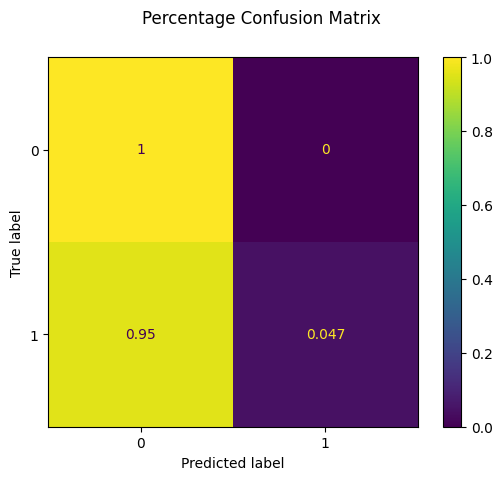

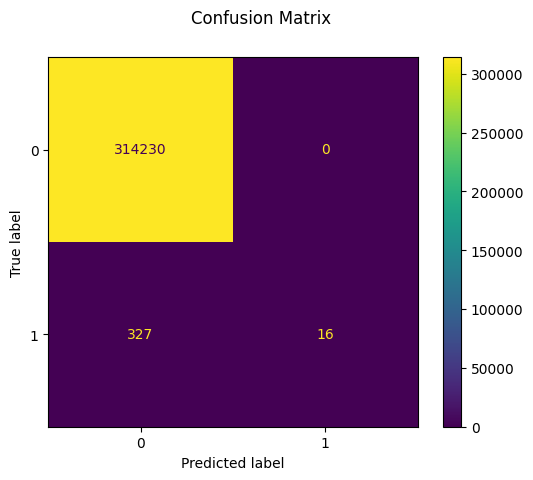

In [34]:
plot_metrics(y_test, y_pred_RidgeClassifier)

## SVM

In [35]:
# Parámetros
# c = 0.01
# kernel = 'linear'
# gamma = 'auto'

In [36]:
# clf_SVM = svm.SVC(C=c, kernel=kernel, gamma=gamma)
# clf_SVM = svm.SVC()
# clf_SVM.fit(x_train_scaled, y_train)

In [37]:
filename = '../models/SVM_model.sav'
# save the model to disk
# pickle.dump(clf_SVM, open(filename, 'wb'))
 
# load the model from disk
clf_SVM = pickle.load(open(filename, 'rb'))

In [38]:
y_pred_SVM = clf_SVM.predict(x_test_scaled)


F2 Score: 0.5340450069668458

R2 Score: 0.0543624941304528

Accuracy Score: 0.998970032393117

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       1.00      0.06      0.10       343

    accuracy                           1.00    314573
   macro avg       1.00      0.53      0.55    314573
weighted avg       1.00      1.00      1.00    314573



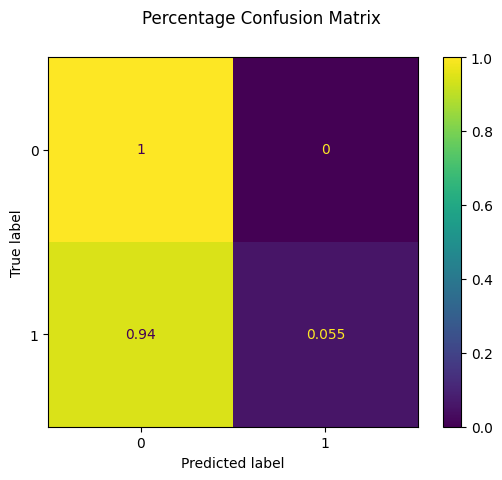

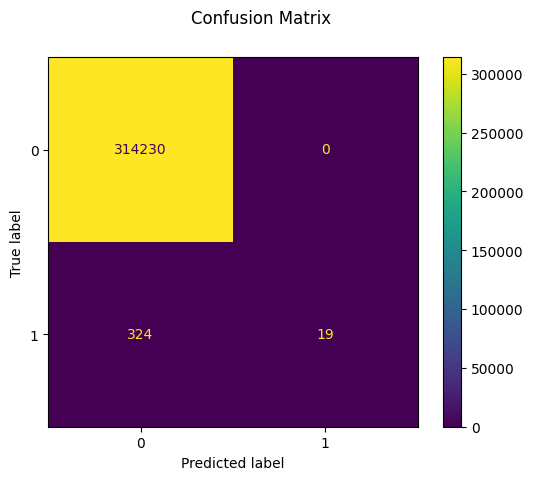

In [39]:
plot_metrics(y_test, y_pred_SVM)

## Random Forest

In [40]:
# clf_RandomForest = RandomForestClassifier()
# clf_RandomForest.fit(x_train_scaled, y_train)

In [41]:
filename = '../models/RandomForest_model.sav'
# save the model to disk
# pickle.dump(clf_RandomForest, open(filename, 'wb'))
 
# load the model from disk
clf_RandomForest = pickle.load(open(filename, 'rb'))

In [42]:
y_pred_RandomForest = clf_RandomForest.predict(x_test_scaled)
y_pred_RandomForest_prob = clf_RandomForest.predict_proba(x_test_scaled)


F2 Score: 0.900092580023386

R2 Score: 0.7548347207004877

Accuracy Score: 0.9997329713611784

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.76      0.86       343

    accuracy                           1.00    314573
   macro avg       0.99      0.88      0.93    314573
weighted avg       1.00      1.00      1.00    314573



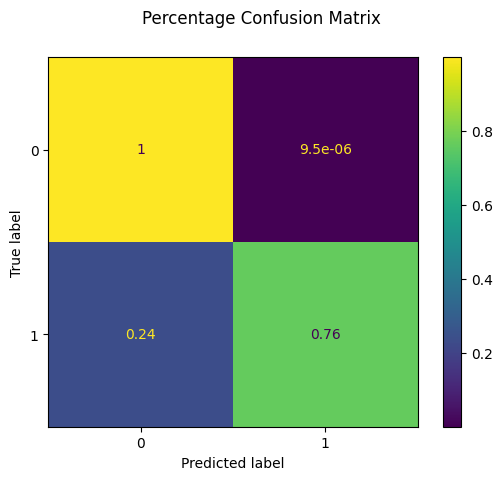

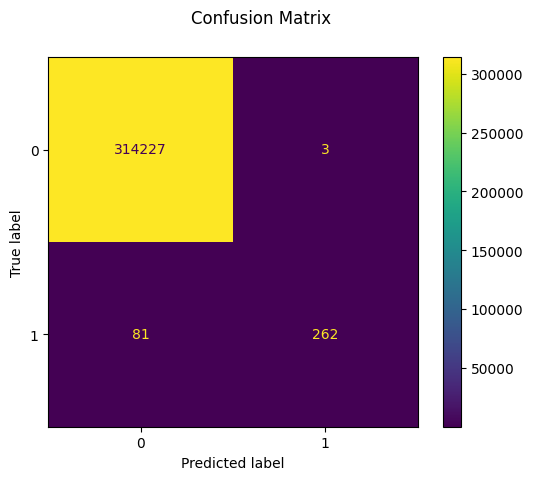

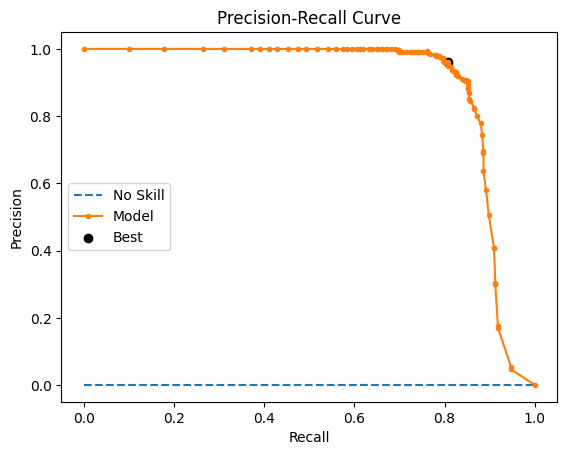

Model PR AUC: 0.8936310553400653
Best Threshold=0.330000, F-Score=0.878


In [43]:
plot_metrics(y_test, y_pred_RandomForest, y_pred_RandomForest_prob, Y)

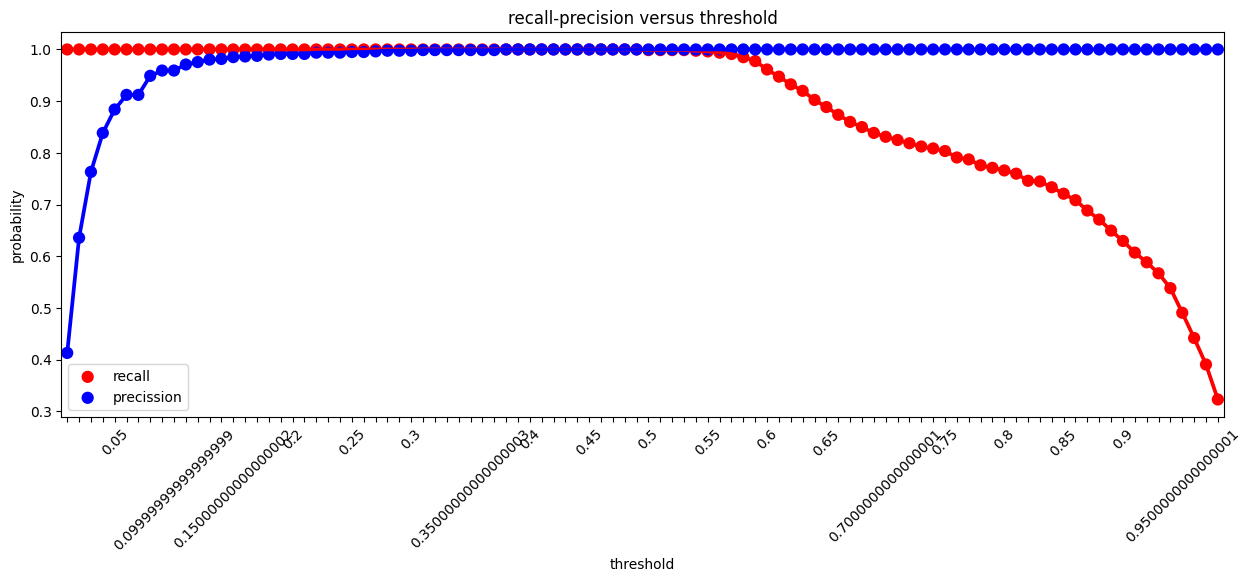

In [44]:
plot_threshold(clf_RandomForest, x_train_scaled, x_test_scaled, y_train, y_test)

## XGBBoost

In [45]:
# clf_XGBBoost = XGBClassifier()
# clf_XGBBoost.fit(x_train_scaled, y_train)

In [46]:
filename = '../models/XGBBoost_model.sav'
# save the model to disk
# pickle.dump(clf_XGBBoost, open(filename, 'wb'))
 
# load the model from disk
clf_XGBBoost = pickle.load(open(filename, 'rb'))

In [47]:
y_pred_XGBBoost = clf_XGBBoost.predict(x_test_scaled)
y_pred_XGBBoost_prob = clf_XGBBoost.predict_proba(x_test_scaled)


F2 Score: 0.9282054580640052

R2 Score: 0.8219633090801162

Accuracy Score: 0.9998060863456177

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.83      0.90       343

    accuracy                           1.00    314573
   macro avg       1.00      0.91      0.95    314573
weighted avg       1.00      1.00      1.00    314573



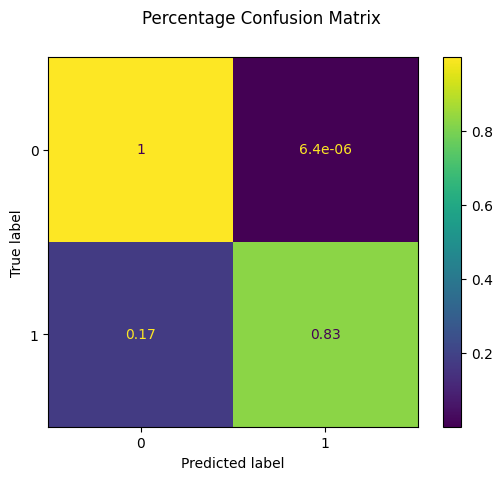

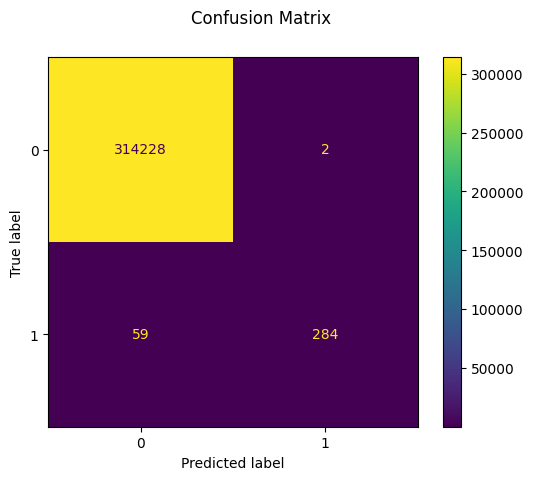

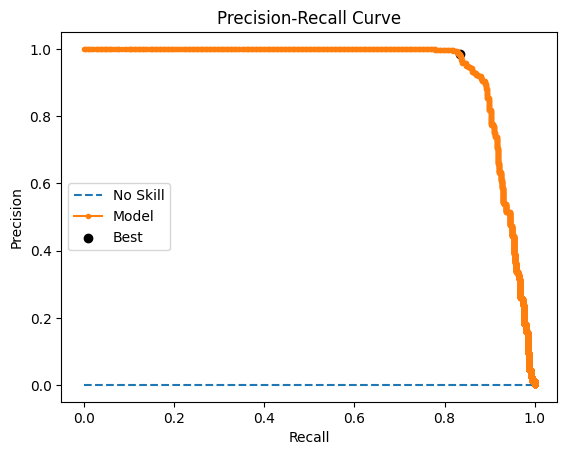

Model PR AUC: 0.9369843144519565
Best Threshold=0.427354, F-Score=0.904


In [48]:
plot_metrics(y_test, y_pred_XGBBoost, y_pred_XGBBoost_prob, Y)

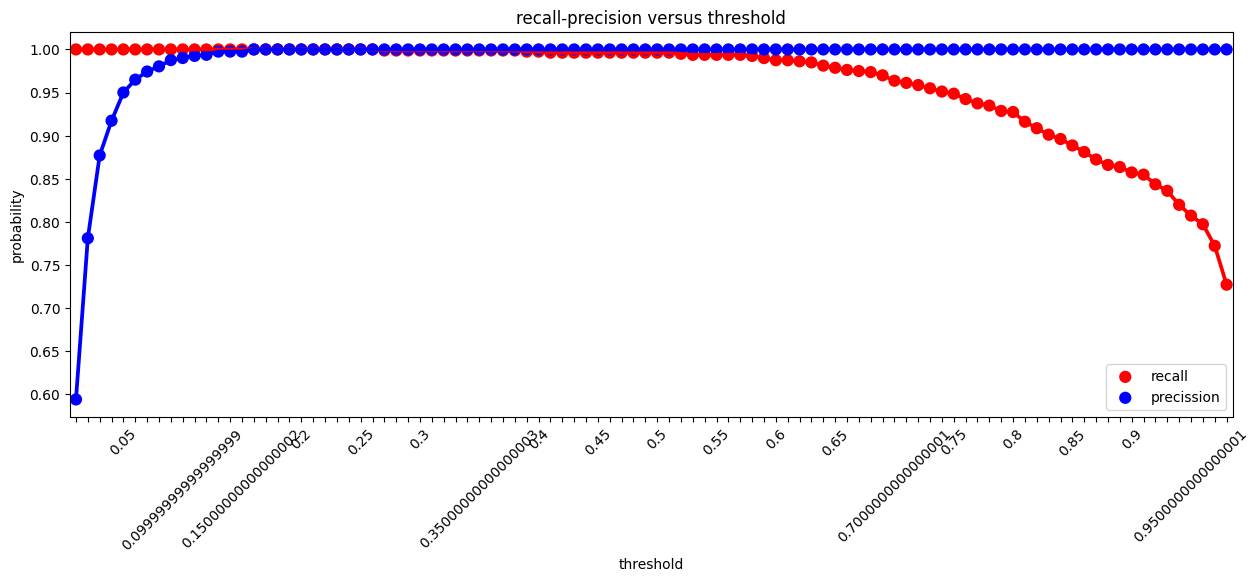

In [49]:
plot_threshold(clf_XGBBoost, x_train_scaled, x_test_scaled, y_train, y_test)

## LightGBM

We use the benchmarks we saw in an example of a problem similar to ours.

In [50]:
# clf_LightGBM = LGBMClassifier(n_estimators=180,
#                     application= 'binary',
#                     objective= 'binary',
#                     metric= 'binary_logloss',
#                     boosting='gbdt',
#                     num_leaves= 50,
#                     min_data_in_leaf= 200,
#                     feature_fraction= 0.8,
#                     bagging_fraction= 0.8,
#                     learning_rate= 0.01,
#                     max_depth= 12,
#                     verbose= 1)

# clf_LightGBM.fit(x_train_scaled, y_train)

In [51]:
# save the model to disk
filename = '../models/LightGBM_model.sav'
# pickle.dump(clf_LightGBM, open(filename, 'wb'))
 
# load the model from disk
clf_LightGBM = pickle.load(open(filename, 'rb'))

In [52]:
y_pred_LightGBM = clf_LightGBM.predict(x_test_scaled)
y_pred_LightGBM_prob = clf_LightGBM.predict_proba(x_test_scaled)


F2 Score: 0.9151244660207468

R2 Score: 0.7869396977516143

Accuracy Score: 0.9997679393972146

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.80      0.88       343

    accuracy                           1.00    314573
   macro avg       0.99      0.90      0.94    314573
weighted avg       1.00      1.00      1.00    314573



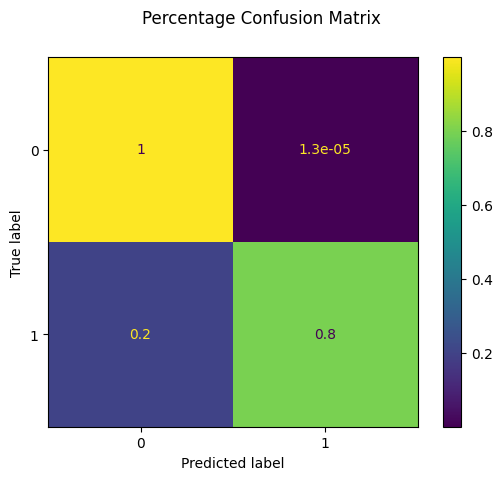

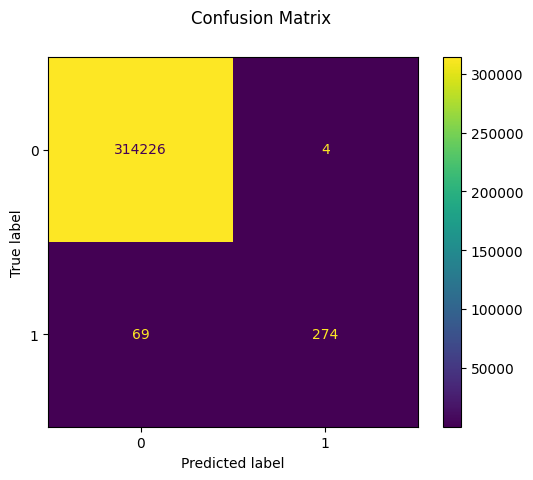

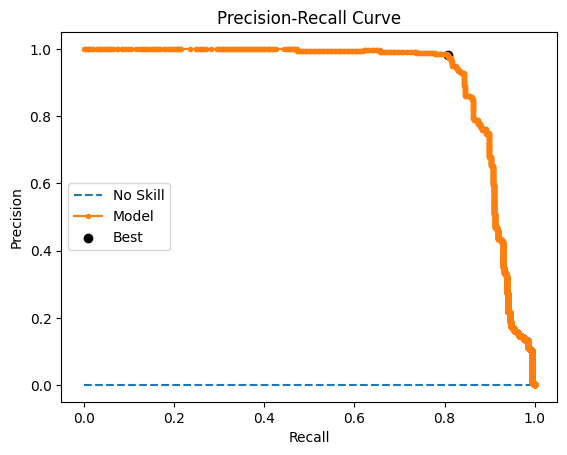

Model PR AUC: 0.9112114665975284
Best Threshold=0.460974, F-Score=0.886


In [53]:
plot_metrics(y_test, y_pred_LightGBM, y_pred_LightGBM_prob, Y)

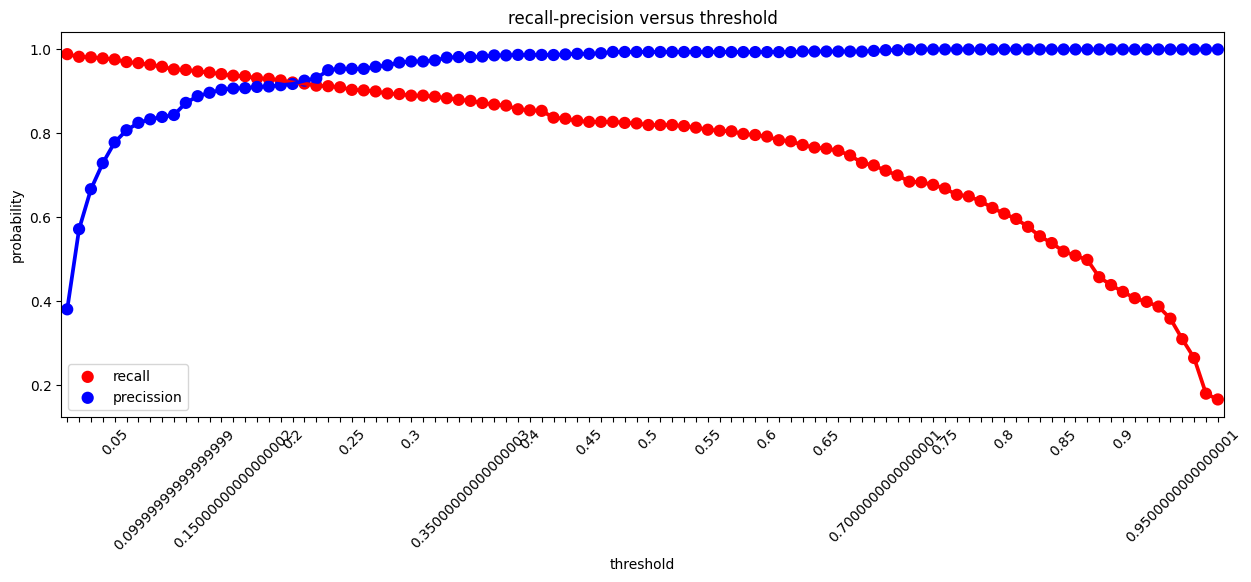

In [54]:
plot_threshold(clf_LightGBM, x_train_scaled, x_test_scaled, y_train, y_test)

## K-Means

In [55]:
# Parameters
k = 2

In [56]:
# clf_Kmeans = KMeans(n_clusters=k, random_state = seed)
# clf_Kmeans.fit(x_train_scaled)

In [57]:
filename = '../models/KMeans_model.sav'
# save the model to disk
# pickle.dump(clf_Kmeans, open(filename, 'wb'))
 
# load the model from disk
clf_Kmeans = pickle.load(open(filename, 'rb'))

In [58]:
y_pred_Kmeans = clf_Kmeans.predict(x_test_scaled)


F2 Score: 0.35477089923798016

R2 Score: -310.2752643163367

Accuracy Score: 0.6609658171553184

              precision    recall  f1-score   support

           0       1.00      0.66      0.80    314230
           1       0.00      0.00      0.00       343

    accuracy                           0.66    314573
   macro avg       0.50      0.33      0.40    314573
weighted avg       1.00      0.66      0.80    314573



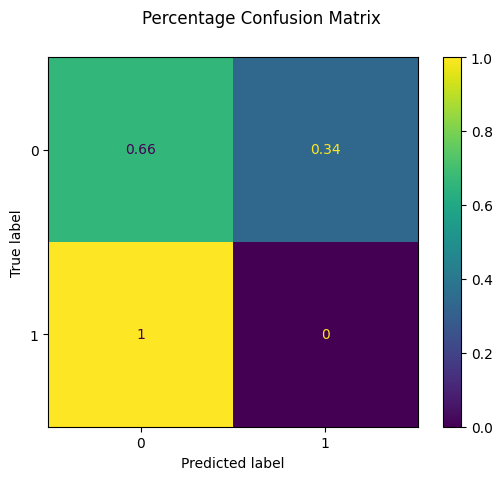

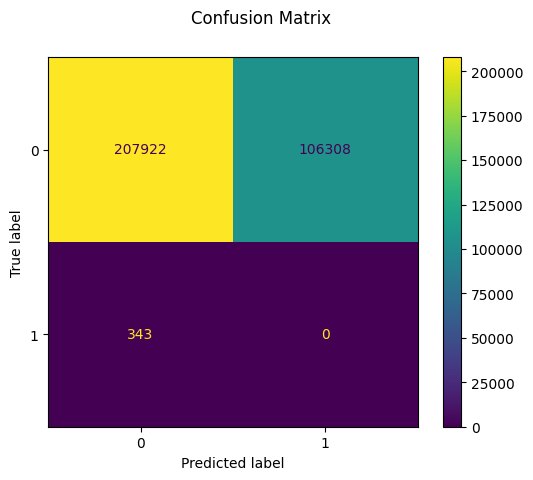

In [59]:
plot_metrics(y_test, y_pred_Kmeans)

## Naive Bayes

In [60]:
# clf_gnb = GaussianNB()
# clf_gnb.fit(x_train_scaled, y_train)

In [61]:
filename = '../models/GaussianNB_model.sav'
# save the model to disk
# pickle.dump(clf_gnb, open(filename, 'wb'))
 
# load the model from disk
clf_gnb = pickle.load(open(filename, 'rb'))

In [62]:
y_pred_gnb = clf_gnb.predict(x_test_scaled)
y_pred_gnb_prob = clf_gnb.predict_proba(x_test_scaled)


F2 Score: 0.3143461699449343

R2 Score: -400.30345723625044

Accuracy Score: 0.5629090862852184

              precision    recall  f1-score   support

           0       1.00      0.56      0.72    314230
           1       0.00      1.00      0.00       343

    accuracy                           0.56    314573
   macro avg       0.50      0.78      0.36    314573
weighted avg       1.00      0.56      0.72    314573



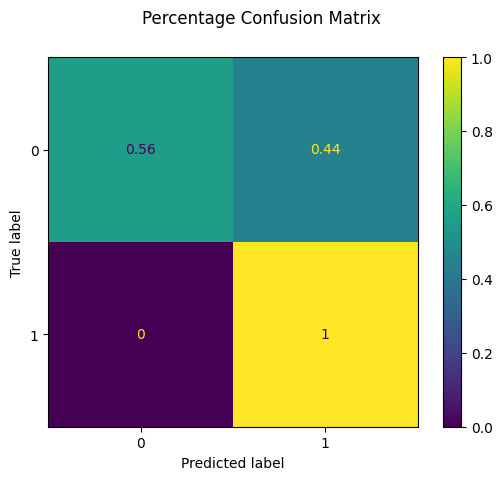

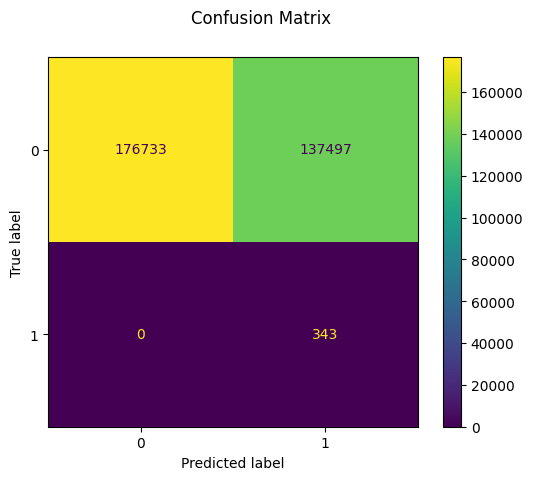

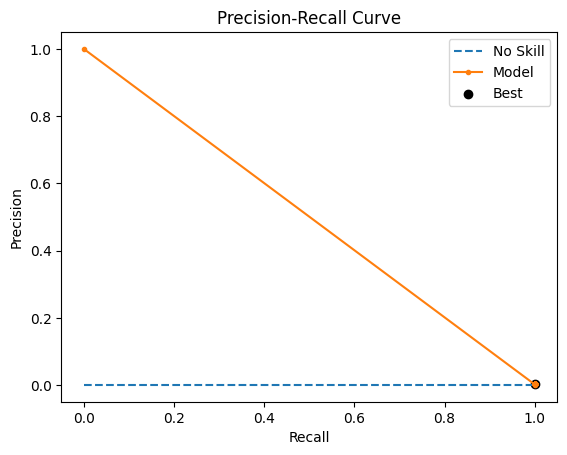

Model PR AUC: 0.5012583369408105
Best Threshold=1.000000, F-Score=0.005


In [63]:
plot_metrics(y_test, y_pred_gnb, y_pred_gnb_prob, Y)

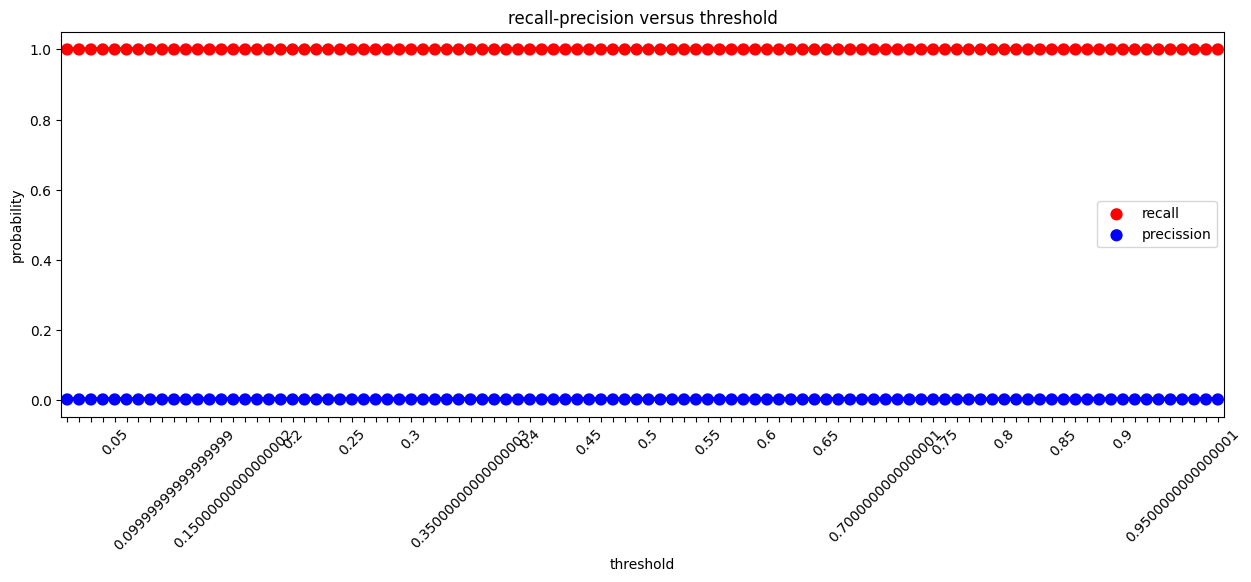

In [64]:
plot_threshold(clf_gnb, x_train_scaled, x_test_scaled, y_train, y_test)

# Conclusions

We want to penalize false denials (it is more costly to detect a fraudulent transaction as NOT FRAUDULENT than to detect a NON-fraudulent transaction as FRAUDULENT).

We have generated so many metrics in case we need to contrast in the future. But to select the best model we looked at the f2-score metric.

The f-beta score determines the weight of recall in the combined score. While beta > 1 favors recall.

Recall is defined as the number of true positives over the number of true positives plus the number of false negatives.

#### Let us analyze all the f2-scores obtained:

In [77]:
models_list = [clf_dummy, clf_gnb, clf_Kmeans, clf_logistic, clf_RandomForest, clf_LogisticLasso, clf_SVM, clf_RidgeClassifier]

In [87]:
for model in models_list:
    y_pred = model.predict(x_test_scaled)
    print(f'F2 Score in {model}: {fbeta_score(y_test, y_pred, beta=2, average="macro")}\n') # F2-Score

F2 Score in DummyClassifier(strategy='most_frequent'): 0.4998908681107711

F2 Score in GaussianNB(): 0.3143461699449343

F2 Score in KMeans(n_clusters=2, random_state=1243): 0.35477089923798016

F2 Score in LogisticRegression(): 0.560356875756082

F2 Score in RandomForestClassifier(): 0.900092580023386

F2 Score in LogisticRegression(penalty='l1', random_state=1243, solver='liblinear'): 0.6794411073958972

F2 Score in SVC(): 0.5340450069668458

F2 Score in RidgeClassifier(): 0.528714401555882



In [79]:
y_pred = clf_LightGBM.predict(x_test_scaled)
print(f'\nF2 Score in {clf_LightGBM}: {fbeta_score(y_test, y_pred, beta=2, average="macro")}\n') # F2-Score


F2 Score in LGBMClassifier(application='binary', bagging_fraction=0.8, boosting='gbdt',
               feature_fraction=0.8, learning_rate=0.01, max_depth=12,
               metric='binary_logloss', min_data_in_leaf=200, n_estimators=180,
               num_leaves=50, objective='binary', verbose=1): 0.9151244660207468



In [80]:
y_pred = clf_XGBBoost.predict(x_test_scaled)
print(f'\nF2 Score in {clf_XGBBoost}: {fbeta_score(y_test, y_pred, beta=2, average="macro")}\n') # F2-Score


F2 Score in XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...): 0.9282054580640052



- We see that the best F2-score obtained are clearly in the assembled models: Random Forest, LightGBM and XGBoost.
- Let's take a closer look at its metrics.


F2 Score: 0.900092580023386

R2 Score: 0.7548347207004877

Accuracy Score: 0.9997329713611784

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.76      0.86       343

    accuracy                           1.00    314573
   macro avg       0.99      0.88      0.93    314573
weighted avg       1.00      1.00      1.00    314573



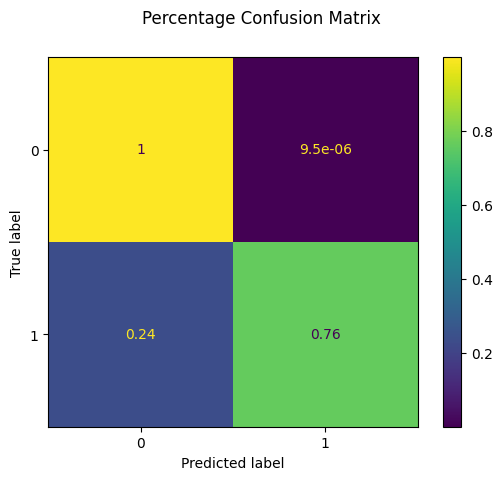

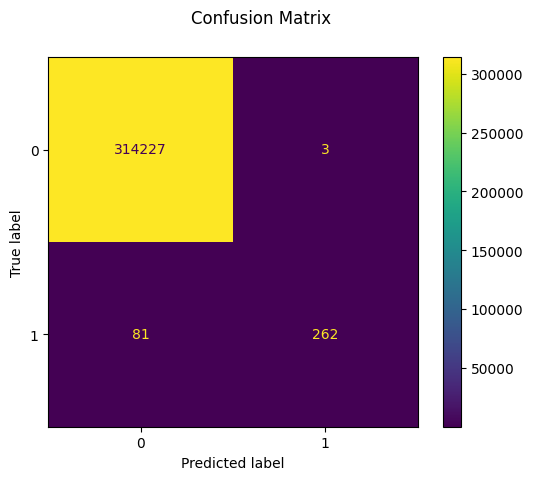

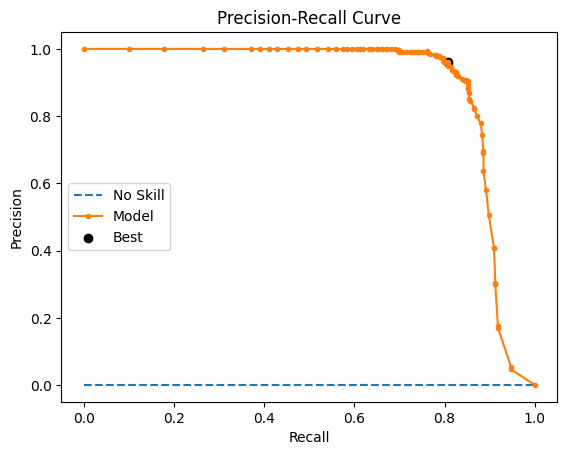

Model PR AUC: 0.8936310553400653
Best Threshold=0.330000, F-Score=0.878


In [85]:
# Random Forest
plot_metrics(y_test, y_pred_RandomForest, y_pred_RandomForest_prob, Y)


F2 Score: 0.9151244660207468

R2 Score: 0.7869396977516143

Accuracy Score: 0.9997679393972146

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.80      0.88       343

    accuracy                           1.00    314573
   macro avg       0.99      0.90      0.94    314573
weighted avg       1.00      1.00      1.00    314573



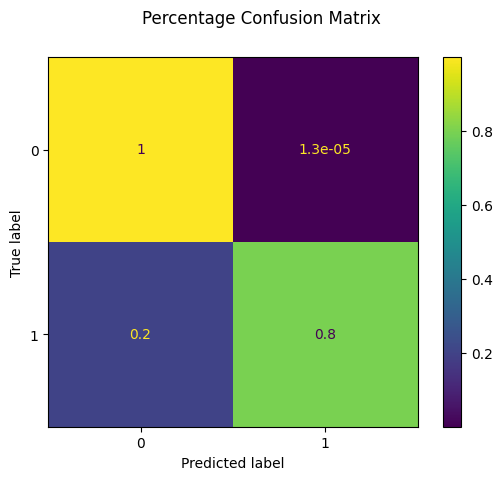

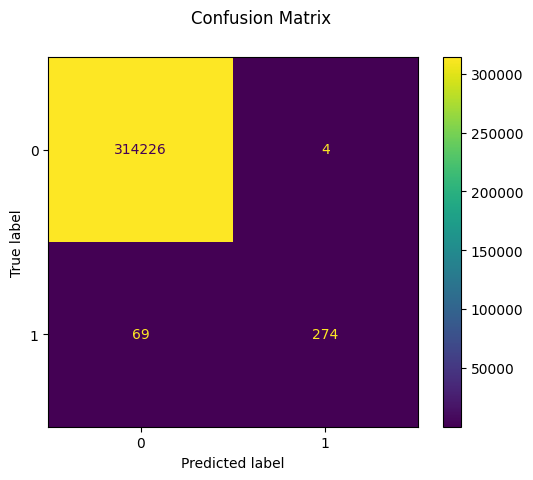

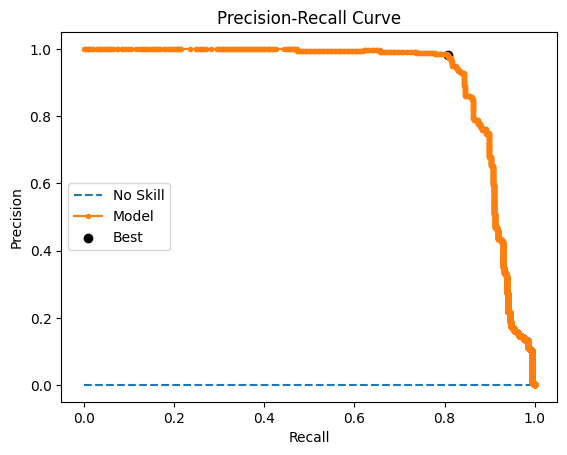

Model PR AUC: 0.9112114665975284
Best Threshold=0.460974, F-Score=0.886


In [82]:
# LightGBM
plot_metrics(y_test, y_pred_LightGBM, y_pred_LightGBM_prob, Y)


F2 Score: 0.9282054580640052

R2 Score: 0.8219633090801162

Accuracy Score: 0.9998060863456177

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.83      0.90       343

    accuracy                           1.00    314573
   macro avg       1.00      0.91      0.95    314573
weighted avg       1.00      1.00      1.00    314573



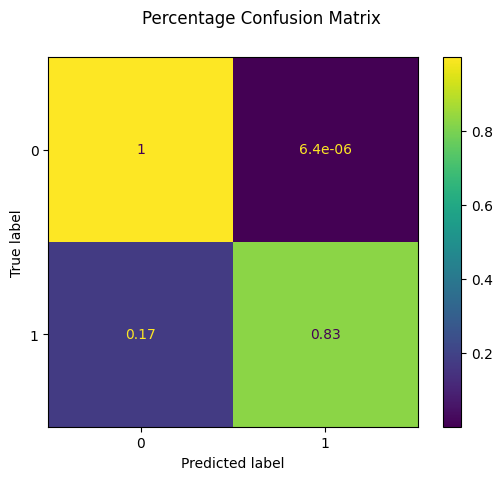

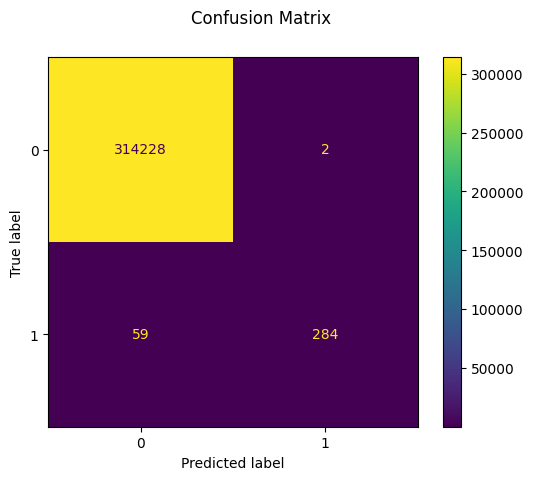

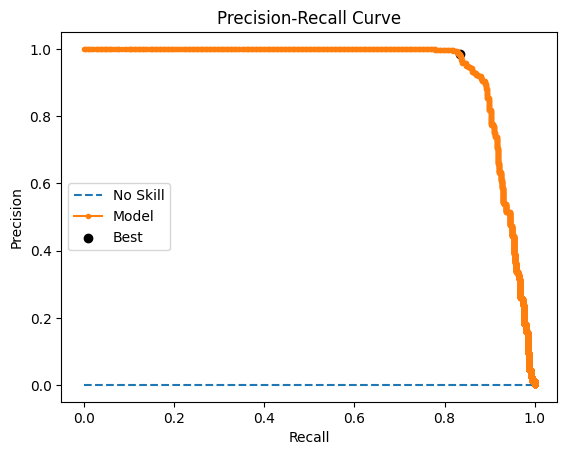

Model PR AUC: 0.9369843144519565
Best Threshold=0.427354, F-Score=0.904


In [84]:
# XGBoost
plot_metrics(y_test, y_pred_XGBBoost, y_pred_XGBBoost_prob, Y)

As we have explained above, the metric we are most interested in this problem is the Recall.
So focusing on Recall, in False Positive and in PR AUC, we choose XGBoost as the best of our models.